In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [37]:
n = 10000

In [38]:
ht_samples = np.random.pareto(1.5, size=n)
sg_samples = np.abs(np.random.normal(loc=0, scale=2, size=n))

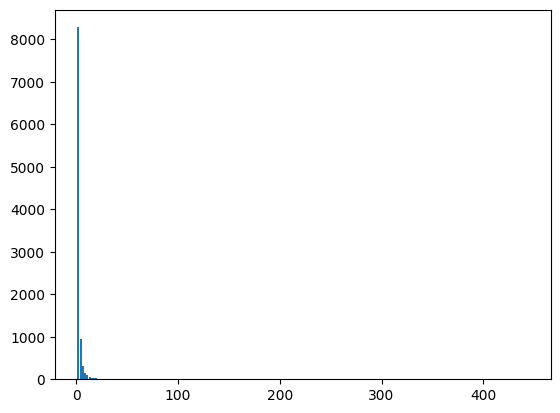

In [58]:
y, x = np.histogram(ht_samples, bins=200)
plt.bar(x[1:], y, width=2)
plt.savefig('ht_dist.pdf', format='pdf')

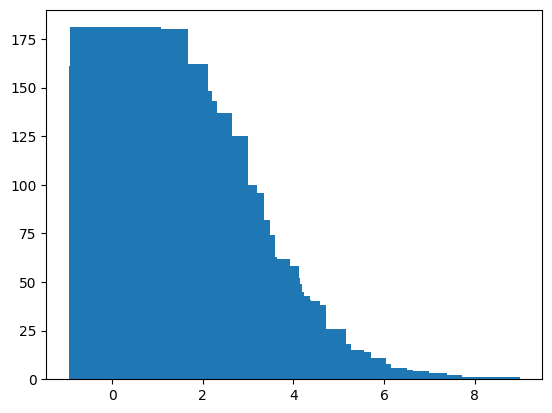

In [59]:
y, x = np.histogram(sg_samples, bins=200)
plt.bar(x[1:], y, width=2)
plt.savefig('sg_dist.pdf', format='pdf')

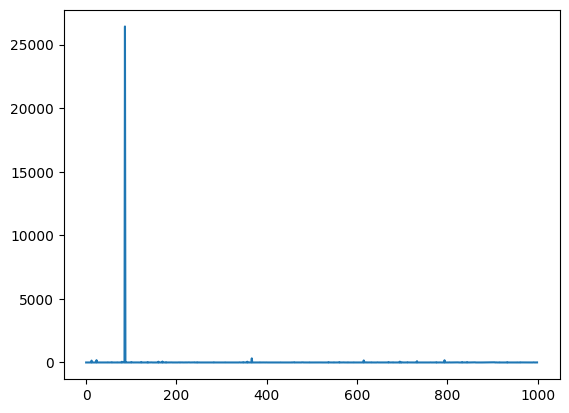

In [6]:
plt.plot(ht_samples)

In [ ]:
# from ucimlrepo import fetch_ucirepo 

In [ ]:
# # fetch dataset 
# ecoli = fetch_ucirepo(id=39) 
# vehicle = fetch_ucirepo(id=149)
# satimage = fetch_ucirepo(id=146)

In [10]:
# import pandas as pd
# import os
# from pathlib import Path
# import numpy as np



In [11]:
# categorical_columns = data.select_dtypes(include=['object', 'category']).columns


In [12]:
# categorical_columns

In [13]:

# # Convert categorical columns to one-hot encoding
# df_one_hot = pd.get_dummies(data, columns=categorical_columns)

In [1]:
from faulty_policy import SoftmaxDataPolicy
from sklearn.model_selection import train_test_split
import pandas as pd
import os
from pathlib import Path
import numpy as np
from sklearn.preprocessing import LabelEncoder


In [2]:
# meta = []
# names = []
# ps = {'train': [], 'test': []}
# qs = {'train': [], 'test': []}
# rs = {'train': [], 'test': []}
# true_reward = {'train':[], 'test': []}
# for filename in sorted(os.listdir('UCI')):
#     df = pd.read_csv(Path('UCI') / filename)
#     label_encoder = LabelEncoder()
#     y = label_encoder.fit_transform(df[df.columns[-1]])
#     categorical_columns = df.select_dtypes(include=['object', 'category']).columns
#     action_size = len(df[df.columns[-1]].unique())
#     df = pd.get_dummies(df, columns=categorical_columns)
#     x = df.values[:, :-action_size].astype(np.float32)
#     print(x.shape, y.shape)
#     # p = np.ones(y.shape) / y.shape[-1]
#     # data = np.concatenate([x, y, p], axis=1)
#     train, test = train_test_split(np.concatenate([x, y[:, None]], axis=1), test_size=0.8, random_state = 2025)
#     y = {
#         'train': train[:, -1].astype(int),
#         'test': test[:, -1].astype(int)
#     }
#     print(train.shape, test.shape)
#     names.append(filename[:filename.rindex(".")])
#     meta.append([x.shape[-1], action_size])
#     logging_policy = SoftmaxDataPolicy(train[:, :-1], train[:, -1], 
#                                test[:, :-1], test[:, -1], 
#                                action_set=np.arange(action_size),
#                                temperature=1.0, 
#                                faulty_actions=np.arange(action_size)
#                                )
#     target_policy = SoftmaxDataPolicy(train[:, :-1], train[:, -1], 
#                                test[:, :-1], test[:, -1], 
#                                action_set=np.arange(action_size),
#                                temperature=1.0, 
#                                faulty_actions=[]
#                                )
#     for mode in ['train', 'test']:
#         logging_probs = logging_policy.get_probs(mode)
#         target_probs = target_policy.get_probs(mode)
#         # print(logging_probs[0])
#         # print(target_probs[0])
#         action = np.array([np.random.choice(action_size, p=prob) for prob in logging_probs])
#         p = target_probs[np.arange(len(target_probs)), action]
#         q = logging_probs[np.arange(len(target_probs)), action]
#         r = (action == y[mode]).astype(float)
#         true_reward[mode].append(np.mean(target_probs[np.arange(len(target_probs)), y[mode]]))
#         ps[mode].append(p)
#         qs[mode].append(q)
#         rs[mode].append(r)
        

In [3]:
# true_reward['train']

In [4]:
def calculate_pm_expected_value(pm_lambda, q, p, func_values):
    w =  p / q
    power_mean_w = w / (1 - pm_lambda + (pm_lambda * w))
    return np.mean(func_values * power_mean_w)

def calculate_es_expected_value(es_lambda, q, p, func_values):
    return np.mean(func_values * p / (q ** es_lambda))

def calculate_ls_expected_value(ls_lambda, q, p, func_values):
    return -np.mean((1 / ls_lambda) * p * np.log(1 - ((ls_lambda * func_values) / (q + 1e-8))))

def calculate_lsnl_expected_value(ls_lambda, q, p, func_values):
    return -np.mean((1 / ls_lambda) * np.log(1 - ((ls_lambda * func_values * p) / (q + 1e-8))))

def calculate_ops_expected_value(ops_lambda, q, p, func_values):
    w = p / q
    w2 = w * w
    ops_w = (ops_lambda * w) / (w2 + ops_lambda)
    return np.mean(ops_w * func_values)

def calculate_ix_expected_value(ix_lambda, q, p, func_values):
    return np.mean(func_values * p / (q + ix_lambda))

def calculate_tr_expected_value(tr_lambda, q, p, func_values):
    return np.mean(func_values * np.minimum(p / q, tr_lambda))

def calculate_sn_expected_value(tr_lambda, q, p, func_values):
    return np.mean(func_values * (p / q)) / np.mean(p / q)

def calculate_lse_expected_value(lse_lambda, q, p, func_values):
    if lse_lambda <= 0:
        return np.mean(func_values * (p/q))
    result = lse_lambda * (func_values) * (p / q)
    result = np.exp(result)
    result = np.log(np.mean(result))
    return ((1 / lse_lambda) * result)

def calculate_lsen_expected_value(lse_lambda, q, p, func_values):
    result = lse_lambda * (func_values) * (p / q)
    result = np.exp(result)
    dom = np.exp(lse_lambda * (p / q))
    result = np.log(np.mean(result) / (np.mean(dom) + 1e-8))
    return ((1 / lse_lambda) * result)


def calculate_mrdr_expected_value(mrdr_lambda, q, p, func_values):
    return np.mean((1 - q) * p * func_values / q ** 2)



In [5]:
from scipy.optimize import minimize
from functools import partial


In [23]:
def get_hyperparameter(method, p, q, n, r):
    significance = 0.1
    if method == 'pm':
        d2_Renyi = np.mean(p ** 2 / q)
        out = (np.log(1 / significance) / (3 * d2_Renyi * n)) ** 0.5
        return np.array([out])
    if method == 'ix':
        out = (np.log(2 / significance) / n) ** 0.5
        return np.array([out])
    if method == 'es':
        return np.array([0.0, 0.3, 0.5, 0.7, 1.0])
    if method == 'lse':
        # return np.array([1 / n ** 0.5])
        return np.array([0.0, 0.001, 0.01, 0.1, 1.0])
    if method in ['ls', 'tr']: 
        return np.array([1 / n ** 0.5])
    if method in ['mrdr', 'sn']:
        return np.array([1.0])
    if method == 'os':
        def obj(lambda_):
            shrinkage_weight = (lambda_ * (p/q)) / ((p/q) ** 2 + lambda_)
            estimated_rewards_ = shrinkage_weight * r
            variance = np.var(estimated_rewards_)
            bias = np.sqrt(np.mean((p/q - shrinkage_weight) ** 2)) * max(r)
            return bias ** 2 + variance
        landa_opt = minimize(obj, x0=np.array([1]), bounds=[(0, np.inf)], method='Powell').x
        return np.array([landa_opt])


In [24]:
estimators = {
    "pm": {
        'param': partial(get_hyperparameter, method='pm'),
        'func': calculate_pm_expected_value
    },
    "es": {
        'param': partial(get_hyperparameter, method='es'),
        'func': calculate_es_expected_value
    },
    "ix": {
        'param': partial(get_hyperparameter, method='ix'),
        'func': calculate_ix_expected_value
    },
    "lse": {
        'param': partial(get_hyperparameter, method='lse'),
        'func': calculate_lse_expected_value
    },
    "ls": {
        'param': partial(get_hyperparameter, method='ls'),
        'func': calculate_lsnl_expected_value
    },
    # "ls_lin": {
    #     'param': [0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 1.5, 2, 5],
    #     'func': calculate_ls_expected_value
    # },
    "tr": {
        'param': partial(get_hyperparameter, method='tr'),
        'func': calculate_pm_expected_value
    },
    "os": {
        'param': partial(get_hyperparameter, method='os'),
        'func': calculate_ops_expected_value
    },
    "sn": {
        'param': partial(get_hyperparameter, method='sn'),
        'func': calculate_sn_expected_value
    },
    "mrdr": {
        'param': partial(get_hyperparameter, method='mrdr'),
        'func': calculate_mrdr_expected_value
    },
}

# estimators = {
#     "lse": {
#         'param': np.exp(np.linspace(np.log(0.001), np.log(100), 100)),
#         'func': calculate_lse_expected_value
#     },
#     "lsen": {
#         'param': np.exp(np.linspace(np.log(0.001), np.log(100), 100)),
#         'func': calculate_lsen_expected_value
#     },
#     "sn": {
#         'param': [0.1],
#         'func': calculate_sn_expected_value
#     },
# }

In [30]:
def generate_data(log_temp, target_temp, dataset, noise=None):
    meta = []
    names = []
    ps = {'train': [], 'test': []}
    qs = {'train': [], 'test': []}
    rs = {'train': [], 'test': []}
    true_reward = {'train':[], 'test': []}
    # for filename in sorted(os.listdir('UCI')):
    #     df = pd.read_csv(Path('UCI') / filename)
    df = pd.read_csv(Path('UCI') / dataset)
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df[df.columns[-1]])
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    action_size = len(df[df.columns[-1]].unique())
    df = pd.get_dummies(df, columns=categorical_columns)
    x = df.values[:, :-action_size].astype(np.float32)
    # print(x.shape, y.shape)
    # p = np.ones(y.shape) / y.shape[-1]
    # data = np.concatenate([x, y, p], axis=1)
    train, test = train_test_split(np.concatenate([x, y[:, None]], axis=1), test_size=0.8)
    y = {
        'train': train[:, -1].astype(int),
        'test': test[:, -1].astype(int)
    }
    # print(train.shape, test.shape)
    names.append(dataset[:dataset.rindex(".")])
    meta.append([x.shape[-1], action_size])
    u = action_size // 2
    logging_policy = SoftmaxDataPolicy(train[:, :-1], train[:, -1], 
                            test[:, :-1], test[:, -1], 
                            action_set=np.arange(action_size),
                            temperature=log_temp, 
                            faulty_actions=np.arange(u, action_size)
                            )
    target_policy = SoftmaxDataPolicy(train[:, :-1], train[:, -1], 
                            test[:, :-1], test[:, -1], 
                            action_set=np.arange(action_size),
                            temperature=target_temp, 
                            faulty_actions=np.arange(0, u)
                            )
    for mode in ['train', 'test']:
        logging_probs = logging_policy.get_probs(mode)
        target_probs = target_policy.get_probs(mode)
        # print(logging_probs[0])
        # print(target_probs[0])
        action = np.array([np.random.choice(action_size, p=prob) for prob in logging_probs])
        p = target_probs[np.arange(len(target_probs)), action]
        q = logging_probs[np.arange(len(target_probs)), action]
        r = (action == y[mode]).astype(float)
        tr = np.mean(target_probs[np.arange(len(target_probs)), y[mode]])
        true_reward[mode].append(tr)
        # print(p/q)
        # print(r)
        # print(tr)
        # break
        if noise is not None:
            r += np.random.binomial(n=1, p=noise, size=len(r))
            r = r % 2
        # r = r * 9 + 1
        ps[mode].append(p)
        qs[mode].append(q)
        rs[mode].append(r)
    return names, ps, qs, rs, true_reward

In [31]:
from tqdm import tqdm

In [32]:
n_exp = 10

In [33]:
for estimator, info in estimators.items():
    print(estimator, ":", info['param'])

pm : functools.partial(<function get_hyperparameter at 0x7f7cd43cf0a0>, method='pm')
es : functools.partial(<function get_hyperparameter at 0x7f7cd43cf0a0>, method='es')
ix : functools.partial(<function get_hyperparameter at 0x7f7cd43cf0a0>, method='ix')
lse : functools.partial(<function get_hyperparameter at 0x7f7cd43cf0a0>, method='lse')
ls : functools.partial(<function get_hyperparameter at 0x7f7cd43cf0a0>, method='ls')
tr : functools.partial(<function get_hyperparameter at 0x7f7cd43cf0a0>, method='tr')
os : functools.partial(<function get_hyperparameter at 0x7f7cd43cf0a0>, method='os')
sn : functools.partial(<function get_hyperparameter at 0x7f7cd43cf0a0>, method='sn')
mrdr : functools.partial(<function get_hyperparameter at 0x7f7cd43cf0a0>, method='mrdr')


In [ ]:
from collections import defaultdict
all_lambdas_ls = defaultdict(lambda: 0)
all_lambdas_es = defaultdict(lambda: 0)
for dataset in sorted(os.listdir('UCI')):
    print('-' * 100)
    print(dataset)
    all_errors = {k: [] for k in estimators.keys()}
    for log_temp in [0.6, 0.7, 0.8]:
        for target_temp in [0.1, 0.3, 0.5]:
            for _ in range(n_exp):
                names, ps, qs, rs, true_reward = generate_data(log_temp, target_temp, dataset, noise=0.3)
                for i in range(len(ps['train'])):
                    p = ps['train'][i]
                    q = qs['train'][i]
                    r = rs['train'][i]
                    true_r= true_reward['train'][i]
                    p_test = ps['test'][i]
                    q_test = qs['test'][i]
                    r_test = rs['test'][i]
                    true_r_test = true_reward['test'][i]

                    for estimator, info in estimators.items():
                        best_landa = None
                        best_error = 1000
                        best_est = None
                        for landa in info['param'](p=p, q=q, n=len(p), r=r):
                            est_reward = -(info['func'](landa, q, p, -r))
                            error = np.abs(est_reward - true_r)
                            if error < best_error:
                                best_error = error
                                best_landa = landa
                                best_est = est_reward
                        if estimator == 'lse':
                            all_lambdas_ls[best_landa] += 1
                        if estimator == 'es':
                            all_lambdas_es[best_landa] += 1
                        # print(r_test)
                        est_reward = -(info['func'](best_landa, q_test, p_test, -r_test))
                        error = est_reward - true_r_test
                        all_errors[estimator].append(error)
    print(' Method', '   BIAS', '    VAR', '    MSE')
    print('Best method=', sorted([(k, np.mean(np.array(all_errors[k])**2)) for k in all_errors.keys()], key=lambda x: x[1])[0][0])
    for k, v in all_errors.items():
        bias = np.mean(v)
        mse = np.mean(np.array(v)**2)
        var = mse - bias**2
        print(k.rjust(7, ' '), str(int(bias * 1e+4) / 1e+4).rjust(7, ' '), str(int(var * 1e+4) / 1e+4).rjust(7, ' '), str(int(mse * 1e+4) / 1e+4).rjust(7, ' '))
                        # print('\t', estimator, best_landa, ':', error)
                        


----------------------------------------------------------------------------------------------------
dataset_185_yeast.csv
 Method    BIAS     VAR     MSE
Best method= sn
     pm -0.1235  0.0189  0.0342
     es -0.0213  0.0214  0.0219
     ix -0.2408  0.0126  0.0706
    lse -0.0116  0.0167  0.0168
     ls -0.0573  0.0178  0.0211
     tr -0.1093  0.0231   0.035
     os -0.0329  0.0174  0.0185
     sn  0.0485  0.0092  0.0116
   mrdr 13.2948 294.7946 471.5474
----------------------------------------------------------------------------------------------------
dataset_186_satimage.csv


KeyboardInterrupt: 

In [26]:
print(dict(all_lambdas_ls))

{0.0: 97, 0.1: 98, 0.01: 58, 0.001: 6, 1.0: 71}


In [27]:
print(dict(all_lambdas_es))

{1.0: 162, 0.8: 116, 0.2: 18, 0.5: 33, 0.0: 1}


In [ ]:
print(' Method', '   BIAS', '    VAR', '    MSE')
for k, v in all_errors.items():
    bias = np.mean(v)
    mse = np.mean(np.array(v)**2)
    var = mse - bias**2
    print(k.rjust(7, ' '), str(int(bias * 1e+4) / 1e+4).rjust(7, ' '), str(int(var * 1e+4) / 1e+4).rjust(7, ' '), str(int(mse * 1e+4) / 1e+4).rjust(7, ' '))